# MLE on Finite mixture model with known number of clusters K and item locations V
Assumes user considers all items in universe

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.nn as nn
import random

# Generate Data

In [2]:
U = 5
d = 2
I = 50
K = 2
N = 20
max_epochs= 5000

# Sample items
torch.manual_seed(1)
# Sample items in a slightly larger area than the user preferences. 
# Otherwise the converged solution seem to place user preferences far away from all items
V = dist.Uniform(-1.5,1.5).sample((I,d))

# Sample user profiles
Z_profile = dist.Uniform(-1,1).sample((U,K,d))
#group = dist.Bernoulli(probs=dist.Dirichlet(1.0).sample((N,K)))

In [3]:
group_true = dist.Categorical(probs=torch.ones((K))/K).sample((U,N))# values between 1,..,K with dimension torch.size([U,N])
print(group_true.size())

# Generate Z
Z = torch.zeros((U,N,d))
for n in range(N):
    for u in range(U):
        Z[u,n] = Z_profile[u, group_true[u,n]]

torch.Size([5, 20])


In [4]:
d = (Z.unsqueeze(-2) - V.unsqueeze(0).unsqueeze(0))**2
scores = -d.sum(-1)*7
clicks = dist.Categorical(logits = scores).sample()

In [5]:
clicks

tensor([[29, 29, 35, 35,  6,  5, 26,  0, 46,  0, 37, 46, 21, 37, 21, 37, 38, 26,
         48, 48],
        [40, 11, 35, 21, 18, 18, 18, 35, 29, 10, 21,  9, 11, 21, 21, 40, 32, 48,
         18, 29],
        [48,  5,  8, 48, 44, 37, 37, 36, 46, 38, 44, 46, 37, 37, 37, 37,  5, 36,
         48, 46],
        [46,  1,  3, 42,  0, 33, 42, 42,  0,  3, 46, 46, 38,  0,  1, 42, 44, 19,
          3, 19],
        [37, 38, 32, 49, 38, 29, 29, 37, 38, 11, 38, 32, 13, 29, 34, 36,  5, 11,
         49, 38]])

### Example of clicks (orange), user interest (green) and other items (blue)

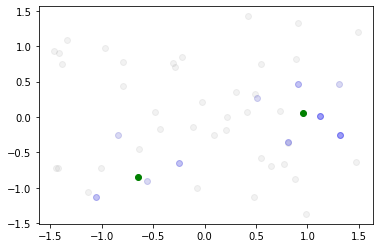

In [6]:
u = 1
plt.scatter(V[:,0],V[:,1], alpha=0.1, color="grey")
plt.scatter(V[clicks][u][:,0], V[clicks][u][:,1], color="blue", alpha=.1)
plt.scatter(Z_profile[u][:,0], Z_profile[u][:,1], color="green")

In [7]:
class OneData(torch.utils.data.Dataset):
    def __init__(self, clicks):
        self.clicks = clicks
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        return self.clicks

ds = OneData(clicks)
dl = torch.utils.data.DataLoader(ds)

In [8]:
import pytorch_lightning as pl
class MixtureRec(pl.LightningModule):
    def __init__(self, clicks, num_users, num_steps, num_groups = 2, dim=2, V=None):
        super().__init__()
        self.clicks = clicks
        self.num_users = num_users
        self.num_steps = num_steps
        self.num_groups = num_groups
        self.dim = dim
        self.V = V#nn.Parameter(torch.rand_like(V))

        # Initialize parameters
        torch.manual_seed(1)
        self.Z_profile = nn.Parameter(dist.Uniform(-1,1).sample((self.num_users,self.num_groups, self.dim)))
        self.group_logit = nn.Parameter(dist.Uniform(-1,1).sample((self.num_users, self.num_steps, self.num_groups)))

    def loglik(self, click):
        # [user, interaction, item, cluster, dim]
        d = (self.Z_profile.unsqueeze(1).unsqueeze(1) - self.V.unsqueeze(0).unsqueeze(0).unsqueeze(-2))**2
        scores = (-d.sum(-1))*7
        exp = self.group_logit.exp()
        mix_probs = (exp/exp.sum(-1).unsqueeze(-1))
        likprob = 0
        for k in range(self.num_groups):
            partial_prob = dist.Categorical(logits=scores[:,:,:,k]).log_prob(clicks)
            likprob += (mix_probs[:,:,k]*partial_prob.exp()).sum()
        loglik = likprob.log()
        return loglik
    
    def logprior(self):
        logprob = 0
        for key, val in self.named_parameters():
            logprob += dist.Normal(torch.zeros_like(val), 10*torch.ones_like(val)).log_prob(val).sum()
        return logprob
    
    def par_noise(self):
        logprob = 0
        for key, val in self.named_parameters():
            logprob += (dist.Normal(torch.zeros_like(val), torch.ones_like(val)).sample()*val).sum()
        return logprob

    def training_step(self, *args, **kwargs):
        loglik = self.loglik(self.clicks)
        logprior = 0#self.par_noise()*1e-2 # self.logprior()
        loss = -(logprior+loglik) / (self.num_users*self.num_steps)
        self.log('train_loss', loss)
        self.log("train_loglik", loglik)
        self.log("train_logprior", logprior)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e+2)
        return optimizer

mix_model = MixtureRec(clicks = clicks, num_users = U, num_groups = K, num_steps = N, V=V)
for key, val in mix_model.named_parameters():
    print(key, val.size())
mix_model

Z_profile torch.Size([5, 2, 2])
group_logit torch.Size([5, 20, 2])


MixtureRec()

In [9]:
trainer = pl.Trainer(progress_bar_refresh_rate=0, max_epochs=max_epochs)
trainer.fit(mix_model, dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type | Params
------------------------------
------------------------------
220       Trainable params
0         Non-trainable params
220       Total params
0.001     Total estimated model params size (MB)
/Users/simeneide/anaconda3/envs/py37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


### Visualize some users with estimated user locations (red), true user locations (green), clicks (blue) and all items (grey)

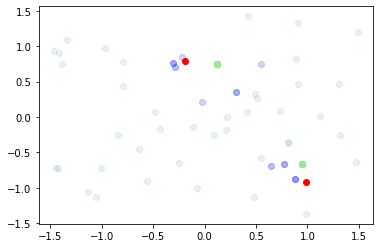

In [10]:
u = 3
Z_profile_hat = mix_model.Z_profile.detach()
V_hat = mix_model.V.detach()
plt.scatter(V_hat[:,0],V_hat[:,1], alpha=0.1)
plt.scatter(Z[u][:,0], Z[u][:,1],color="lightgreen")
plt.scatter(Z_profile_hat[u][:,0], Z_profile_hat[u][:,1], color="red")
plt.scatter(V_hat[clicks][u][:,0], V_hat[clicks][u][:,1], alpha=0.1, color="blue")

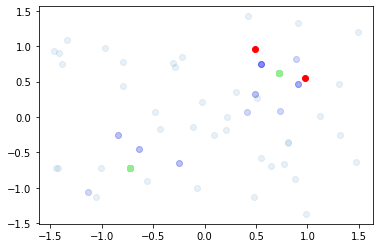

In [11]:
u = 4
Z_profile_hat = mix_model.Z_profile.detach()
plt.scatter(V[:,0],V[:,1], alpha=0.1)
plt.scatter(Z[u][:,0], Z[u][:,1],color="lightgreen")
plt.scatter(Z_profile_hat[u][:,0], Z_profile_hat[u][:,1], color="red")
plt.scatter(V[clicks][u][:,0], V[clicks][u][:,1], alpha=0.1, color="blue")

## Modify z_profile by manually moving to correct cluster and see if likelihood increases

In [12]:
mix_model.Z_profile[4,]

tensor([[0.9778, 0.5515],
        [0.4944, 0.9632]], grad_fn=<SelectBackward>)

In [13]:
print("Old likelihood")
print(mix_model.loglik(clicks))

Old likelihood
tensor(2.8659, grad_fn=<LogBackward>)


In [14]:
old_point = mix_model.Z_profile[4,1]
optimal_point = torch.tensor([-0.75,-0.75])
# Move linearlly from previous point to true point
num=10
weights = torch.linspace(0,1, num)
moving_loglik = torch.zeros_like(weights)
for i, w in enumerate(weights):
    weighted_point = (1-w)*old_point + w*optimal_point
    mix_model.Z_profile[u,1] = weighted_point
    moving_loglik[i] = mix_model.loglik(clicks)

Text(0.5, 1.0, 'Showing converged, local optima')

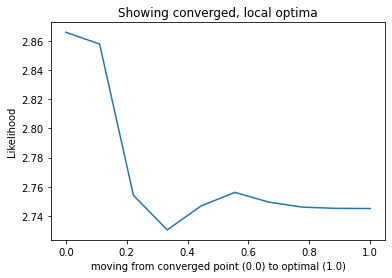

In [15]:
plt.plot(weights.detach(),moving_loglik.detach())
plt.xlabel("moving from converged point (0.0) to optimal (1.0)")
plt.ylabel("Likelihood")
plt.title("Showing converged, local optima")

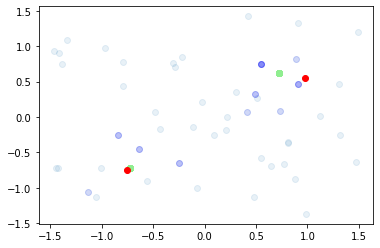

In [16]:
u = 4
Z_profile_hat = mix_model.Z_profile.detach()
plt.scatter(V[:,0],V[:,1], alpha=0.1)
plt.scatter(Z[u][:,0], Z[u][:,1],color="lightgreen")
plt.scatter(Z_profile_hat[u][:,0], Z_profile_hat[u][:,1], color="red")
plt.scatter(V[clicks][u][:,0], V[clicks][u][:,1], alpha=0.1, color="blue")

In [21]:
mix_model.Z_profile[u,1] = old_point

## Conclusion
Using gradient descent on the likelihood, we usually find one cluster, but not both. The two cluster locations tends to be placed at the same point. This seems to be some of the reason that literature argues you should use EM or gibbs when inferring the clusters...

## Gradient descent but optimize the Z_profile in separate step

In [17]:
class TwoStepMix(MixtureRec):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.automatic_optimization = False

    def training_step(self, *args, **kwargs):
        # Step 1: 
        # Relocate each Z_profile where it is most beneficial
        if random.random() > 0.99:
            self.step_1_optim()
        # Step 2:
        opt = self.optimizers()
        opt.zero_grad()
        # General step (including the Z_profile)
        # Compute loss
        loglik = self.loglik(self.clicks)
        logprior = 0#self.par_noise()*1e-2 # self.logprior()
        loss = -(logprior+loglik) / (self.num_users*self.num_steps)

        self.manual_backward(loss)
        opt.step()

        self.log('train_loss', loss)
        self.log("train_loglik", loglik)
        self.log("train_logprior", logprior)
        return loss

    # Potential values
    def step_1_optim(self):
        with torch.no_grad():
            for u in range(self.num_users):
                candidates = V[self.clicks[u]].detach().clone()
                for k in range(self.num_groups):
                    best_loglik = self.loglik(self.clicks)
                    best_vec = self.Z_profile[u,k].detach().clone()
                    for i in range(len(candidates)):
                        cand = candidates[i,]
                        self.Z_profile[u,k] = cand
                        l = self.loglik(self.clicks)
                        if l > best_loglik:
                            best_loglik = l
                            best_vec = cand
                    self.Z_profile[u,k] = best_vec
                    #print(f"u_{u},k_{k}: {best_vec}")
mix_model_twostep = TwoStepMix(clicks = clicks, num_users = U, num_groups = K, num_steps = N, V=V)

In [18]:
trainer = pl.Trainer(progress_bar_refresh_rate=0, max_epochs=max_epochs)
trainer.fit(mix_model_twostep, dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type | Params
------------------------------
------------------------------
220       Trainable params
0         Non-trainable params
220       Total params
0.001     Total estimated model params size (MB)
/Users/simeneide/anaconda3/envs/py37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


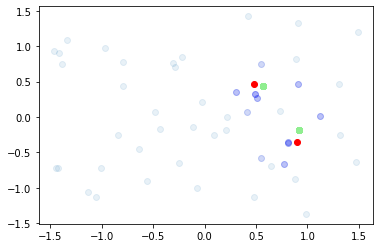

In [19]:
u = 0
Z_profile_hat = mix_model_twostep.Z_profile.detach()
plt.scatter(V[:,0],V[:,1], alpha=0.1)
plt.scatter(Z[u][:,0], Z[u][:,1],color="lightgreen")
plt.scatter(Z_profile_hat[u][:,0], Z_profile_hat[u][:,1], color="red")
plt.scatter(V[clicks][u][:,0], V[clicks][u][:,1], alpha=0.1, color="blue")

## Which perform better?

In [22]:
print("Normal gradient MLE:")
print(mix_model.loglik(clicks))

print("Twostep psuedo-gibbs gradient MLE:")
print(mix_model_twostep.loglik(clicks))

Normal gradient MLE:
tensor(2.6337, grad_fn=<LogBackward>)
Twostep psuedo-gibbs gradient MLE:
tensor(2.8911, grad_fn=<LogBackward>)
